# Getting started

This guide is meant to serve as an example on configuring SilQ and QCoDeS and getting and, and getting a first measurement started that uses a PulseSequence.
All instruments used in this guide are mock instruments, and therefore can be safely executed.
To run this guide, open a Jupyter Notebook, navigate to `SilQ/documentation/Getting started.ipynb`, and run the cells.

The first step is to load the necessary packages, in this case silq and qcodes

In [1]:
import silq
import qcodes as qc

The next step is to initialize an experiment (see [Installation](Installation.rst)).
For this example, we have an experiment called `my_experiment`, whose folder is located in `silq/documentation/code/my_experiment`.

In [2]:
silq.experiments_folder = './code'
silq.initialize('my_experiment')

Initializing imports
Importing often-used packages
Initializing instruments
Loading mock instrument drivers
Initialization complete


Note that initializing an experiment is optional but recommended, as it allows a place to easily store retrieve all experiment configuration, and to easily load instruments.
In fact, most of the code in this guide can be placed inside an init python file in the `experiment_folder`

One more thing we should do is set the data root folder, which is the folder where all the experimental data is stored.
Here we set it to a temporary folder, feel free to change it to whatever you like:

In [3]:
# Create temp folder for data storage
import tempfile
qc.set_data_root_folder(tempfile.mkdtemp())

Data root folder set to C:\Users\Serwan\AppData\Local\Temp\tmpo9a4h9u3


## Initializing instruments

The next step is to initialize the different instruments of the experiment.
For this example experiment, we assume to have the following instruments:

- `trigger_instrument` performs triggering of the other instruments.
  We refer to this instrument as the `primary_instrument`, 
  since starting/stopping this will start/stop the pulse sequence
- `AWG_instrument` outputs waveforms
- `Chip` corresponds to a physical chip used in an experiment.
  This class doesn't do much, but we create this so that other instruments can have a connection to it.
- `digitizer` acquires digitized traces of signals. 
  We refer to this instrument as the `acquisition_instrument`.

We create instances of all these instruments:

In [4]:
from silq.tests.mocks.mock_instruments import (MockTriggerInstrument,
                                               MockAWGInstrument,
                                               MockDigitizerInstrument)
from silq.meta_instruments.chip import Chip

trigger_instrument = MockTriggerInstrument('triggerer')
AWG_instrument = MockAWGInstrument('AWG')
chip = Chip('chip', channels=['DC_gate', 'AC_gate'])
digitizer = MockDigitizerInstrument('digitizer')

The next step is to instantiate InstrumentInterfaces corresponding to each of the instruments.
An InstrumentInterface is a part of SilQ, whose task it is to convert a setup-independent pulse sequence to concrete instructions sent to the underlying instrument.
For more information, see [Targeting a pulse sequence](Concepts in SilQ.rst)

In [5]:
trigger_interface = silq.get_instrument_interface(trigger_instrument)

AWG_interface = silq.get_instrument_interface(AWG_instrument)

chip_interface = silq.get_instrument_interface(chip)

digitizer_interface = silq.get_instrument_interface(digitizer)

Instruments and InstrumentInterfaces usually have a list of Parameters that describe its current settings.
We can see a Parameter list for a given Instrument / InstrumentInterface using:

In [6]:
trigger_instrument.print_snapshot()

triggerer_interface_triggerer :
	parameter value
--------------------------------------------------------------------------------
IDN    :	None 
silent :	False 


Since these are all mock instruments, there aren't many parameters.
However, there is one we should set now: the acquisition sample rate of the digitizer

In [7]:
digitizer_interface.sample_rate(10e3)  # 20 kilosamples / second 

## Initializing Layout

Once we have all the instruments and their interfaces setup, it is time to configure the Layout.
The Layout is a class that represents the physical experimental layout.
It can interact with all the instruments via their interfaces, and it knows the connectivity between instruments.
The layout is used to target a pulse sequence to an experimental setup, meaning that it will distribute the pulses to the appropriate instrument interfaces.
Since it knows the connectivity between instruments, it can also handle tasks such as triggering, by redirecting the ancillary trigger pulses to the right instrument interface.

When we initialize the Layout, we pass it a list of all the instrument interfaces:

In [8]:
from silq.meta_instruments.layout import Layout
layout = Layout(instrument_interfaces=[trigger_interface,
                                       AWG_interface,
                                       chip_interface,
                                       digitizer_interface])

We next perform some initial setup of its parameters:

In [9]:
# These are the channels that the digitizer should acquire. We give each channel a handy label
layout.acquisition_channels([('ch1', 'output'),
                             ('ch2', 'AWG_AC')])

# We also need to specify the primary and acquisition instruments
layout.acquisition_instrument('digitizer')
layout.primary_instrument('triggerer')

We can see a snapshot of its current settings:

In [10]:
layout.print_snapshot()

layout :
	parameter             value
--------------------------------------------------------------------------------
IDN                    :	None 
acquisition_channels   :	[('ch1', 'output'), ('ch2', 'AWG_AC')] 
acquisition_instrument :	digitizer 
active                 :	False 
instruments            :	None 
primary_instrument     :	triggerer 
samples                :	1 
save_trace_channels    :	['output'] 


## Define connections

The layout has a list of all the instruments in the setup, but it also needs to know the connections between the instruments. 
In this case, the connections have already been defined in the experiment config (file `config/connections.json`), but to be explicit, here we redefine them:

In [11]:
silq.config.connections = [
    {'output_arg': 'triggerer.ch1',
     'input_arg': 'AWG.trig_in'},
    {'output_arg': 'triggerer.ch2',
     'input_arg': 'digitizer.trig_in'},
    {'output_arg': 'AWG.ch1',
     'input_arg': 'chip.DC_gate',
     'label': 'stage'},  # We can attach labels to specific connections, which facilitates sending a pulse to that connection.
    {'output_arg': 'AWG.ch2',
     'input_arg': 'chip.AC_gate'},
    {'output_arg': 'AWG.ch2',
     'input_arg': 'digitizer.ch2'},
    # We can also combine connections, meaning that a pulse sent to that connection will be sent to each subconnection.
    {"combine": [["AWG.ch2",   "chip.AC_gate"],
                 ["AWG.ch2", "digitizer.ch2"]],
     "scale": [1, 1],  # We can scale each connection (i.e. the pulse amplitude is multiplied by this value)
     "label": "AC"},
    {'output_arg': 'chip.output',
     'input_arg': 'digitizer.ch1'}
]

Each connection has an output and input arg, which have the form `{instrument_name}.{channel_name}`.
The channels are defined in each InstrumentInterface.

The layout can then directly load these connections from `silq.config.connections`:

In [12]:
layout.load_connections()
layout.connections

[Connection({triggerer.ch1->AWG.trig_in}),
 Connection({triggerer.ch2->digitizer.trig_in}),
 Connection(stage: {AWG.ch1->chip.DC_gate}),
 Connection({AWG.ch2->chip.AC_gate}),
 Connection({AWG.ch2->digitizer.ch2}),
 CombinedConnection AC: 
 	Connection({AWG.ch2->chip.AC_gate})
 	Connection({AWG.ch2->digitizer.ch2}),
 Connection({chip.output->digitizer.ch1})]

## Create and targeting a pulse sequence

The layout has now been set up, which means we can use it to target a pulse sequence.
We can create a pulse sequence as such:

In [13]:
from silq.pulses import DCPulse, PulseSequence

pulse_sequence = PulseSequence()
pulse_sequence.add(DCPulse('empty', amplitude=-1, duration=0.1, connection_label='stage', acquire=True),
                   DCPulse('read', amplitude=0, duration=0.1, connection_label='stage', acquire=True),
                   DCPulse('plunge', amplitude=1, duration=0.1, connection_label='stage', acquire=True))
pulse_sequence

PulseSequence with 3 pulses, duration: 0.3
	DCPulse(empty, A=-1, t_start=0, duration=0.1
		connection_label: stage)
	DCPulse(read, A=0, t_start=0.1, duration=0.1
		connection_label: stage)
	DCPulse(plunge, A=1, t_start=0.2, duration=0.1
		connection_label: stage)

We give each pulse a name, as well as some additional attributes.
Unless `pulse.t_start` is specified, the pulse is appended to the end of the pulse sequence.
We have set the flag `acquire = True` for each pulse, which indicates that the `acquisition_instrument` should acquire the signal trace during this pulse.
Each pulse also has a `connection_label`, which is needed to tell the layout which connection the pulse should go to.
In this case, the pulses are sent to:

In [14]:
layout.get_connection(connection_label='stage')

Connection(stage: {AWG.ch1->chip.DC_gate})

Targeting a pulse sequence is done by setting the layout pulse sequence

In [15]:
layout.pulse_sequence = pulse_sequence

If there are no errors, this means that the instrument interfaces should be able to program their instruments to output this pulse sequence.
Each interface has its own pulse sequence, which contain pulses that it should outputeach of which is targeted to a specific connection.

In [16]:
AWG_interface.pulse_sequence

PulseSequence with 3 pulses, duration: 0.3
	DCPulse(empty, A=-1, t_start=0, duration=0.1
		connection: Connection(stage: {AWG.ch1->chip.DC_gate}))
	DCPulse(read, A=0, t_start=0.1, duration=0.1
		connection: Connection(stage: {AWG.ch1->chip.DC_gate}))
	DCPulse(plunge, A=1, t_start=0.2, duration=0.1
		connection: Connection(stage: {AWG.ch1->chip.DC_gate}))

Looking at the pulse sequences of instrument interfaces can be a useful debugging tool

We can program the instruments using:

In [17]:
layout.samples(100)  # Acquire 100 samples of the pulse sequence
layout.setup()

The instruments are now ready to output the pulse sequence.  

We can now perform an acquisition:

In [18]:
layout.start()  # Start the instruments
pulse_traces = layout.acquisition()  # Perform an acquisition and return the traces
layout.stop()  # Stop the instruments

`pulse_traces` now contains the measured traces, segmented per pulse.
Before we look at the contents of this variable, we first look at the full, unsegmented traces:

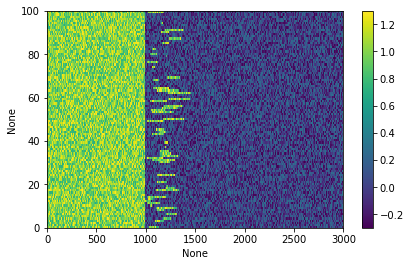

In [19]:
qc.MatPlot(digitizer_interface.traces[0]);  # [0] corresponds to the first channel (output)

The y-axis shows the sample number, and the x-axis is the trace index (acquired at sample rate 10 kHz).

We see three different pulses:

- plunge (between 0 and 1000)
- read (between 1000 and 2000). Here we see occasional blips in the measured current, which could indicate an electron tunneling event.
- empty (between 2000 and 3000)

In the returned variable `pulse_traces`, the raw traces have already been segmented, and so we can look at traces corresponding to each individual pulse:

Text(0.5,1,'Empty pulse')

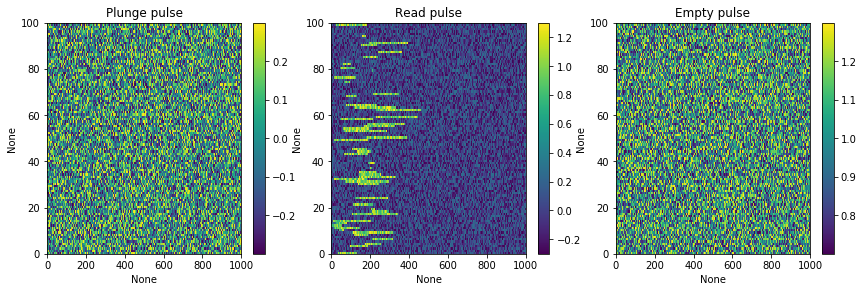

In [20]:
plot = qc.MatPlot(subplots=3)
plot[0].add(pulse_traces['plunge']['output'])
plot[0].set_title('Plunge pulse')
plot[1].add(pulse_traces['read']['output'])
plot[1].set_title('Read pulse');
plot[2].add(pulse_traces['empty']['output'])
plot[2].set_title('Empty pulse');

## Running a measurement loop

So far we have shown how to target a pulse sequence to a specific layout, perform an acquisition and show the resulting traces.
However, there is often a final step to this process, which is analysing the traces and extracting useful information from it.
For this, we have `AcquisitionParameters`.
There are many different types of AcquisitionParameters, each of which is attached to a specific pulse sequence, and has a corresponding analysis.

As an example, we will look at the `VariableReadParameter`, which is used on our experiments to measure a spin tail (where an electron has spin-dependent tunneling).
The pulse sequence is the same as the one used above.
Initializing an Acquisitionparameter will automatically create the attached pulse sequence, and so we first need to globally define some default settings for its pulses.

Default pulse settings are defined in `silq.config.pulses`, and are attached to the name of a pulse:

In [21]:
silq.config.pulses = {
    'plunge': {'duration': 0.05, 'amplitude': 1, 'connection_label': 'stage'},
    'read': {'duration': 0.1, 'amplitude': 0, 'connection_label': 'stage'},
    'empty': {'duration': 0.05, 'amplitude': -1, 'connection_label': 'stage'}
}

Now we are ready to create a `VariableReadParameter`

In [30]:
from silq.parameters.acquisition_parameters import VariableReadParameter
variable_read_parameter = VariableReadParameter()
variable_read_parameter.pulse_sequence

PulseSequence with 3 pulses, duration: 0.2
	DCPulse(plunge, A=1, t_start=0, duration=0.05
		connection_label: stage)
	DCPulse(read, A=0, t_start=0.05, duration=0.1
		connection_label: stage)
	DCPulse(empty, A=-1, t_start=0.15, duration=0.05
		connection_label: stage)

We see that it automatically copies the default pulse values from the config. 
We can easily override these default values

In [31]:
variable_read_parameter.pulse_sequence['empty'].duration = 0.03
variable_read_parameter.pulse_sequence

PulseSequence with 3 pulses, duration: 0.18
	DCPulse(plunge, A=1, t_start=0, duration=0.05
		connection_label: stage)
	DCPulse(read, A=0, t_start=0.05, duration=0.1
		connection_label: stage)
	DCPulse(empty, A=-1, t_start=0.15, duration=0.03
		connection_label: stage)

The analysis of the VariableReadParameter is particularly simply; it simply joins all the pulse traces together and averages these traces over all the samples, resulting in a single averaged time trace.
We can perform the acquisition and subsequent analysis in one go by calling the parameter:

(array([ 0.01989265,  0.01428547, -0.01898348, ...,  0.98850313,
         0.98532145,  1.01357507]),)

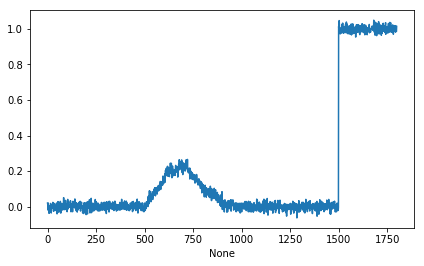

In [34]:
result = variable_read_parameter()
qc.MatPlot(result[0])
result

One important reason why we have combined the acquisition and analysis into a Parameter is that Parameters are used in QCoDeS in a measurement loop.

One typical measurement with this pulse sequence is to measure the averaged trace for a varying read pulse amplitude.
All Pulse properties are also Parameters (although you have to access them slightly differently), and so we can easily create a measurement that varies the read amplitude, and measures the pulse sequence trace:

In [26]:
%%measurement variable_read
for variable_read_parameter.pulse_sequence['read']['amplitude'].sweep(-1, 1, num=21):
    variable_read_parameter
    
loop.run()

DataSet:
   data = load_data('data/2019-03-13/#001_variable_read_14-51-28')
   <Type>   | <array_id>         | <array.name> | <array.shape>
   Setpoint | read_amplitude_set | amplitude    | (21,)
   Setpoint | time_set           | time         | (21, 2000)
   Measured | read_voltage       | read_voltage | (21, 2000)


Once the measurement is complete, the data has been saved in the root data folder (see the first cell for the location).
The output shows the data content, and we can access it as such:

In [35]:
data.read_voltage

DataArray[21,2000]: read_voltage
array([[ 0.01748509,  0.01078835, -0.02103584, ...,  0.97888773,
         1.01976484,  0.98638722],
       [-0.00242784,  0.04555626, -0.00581067, ...,  0.96514436,
         1.0199198 ,  1.00882665],
       [ 0.01917471, -0.00757159,  0.00557461, ...,  1.0090673 ,
         1.01884209,  0.99956237],
       ...,
       [ 0.0045526 , -0.0027798 ,  0.01629096, ...,  1.01591407,
         1.00669397,  1.01389304],
       [-0.02846488,  0.0088031 ,  0.01830787, ...,  0.98936173,
         1.0205617 ,  1.01412097],
       [ 0.00902154, -0.00853018,  0.0085713 , ...,  1.01042134,
         1.00427289,  0.99960007]])

The data output's second line shows the location of the data, and how we can load the existing dataset from disk:

In [37]:
from qcodes import load_data
data = load_data('data/2019-03-13/#001_variable_read_14-51-28')
data

DataSet:
   data = load_data('data/2019-03-13/#001_variable_read_14-51-28')
   <Type>   | <array_id>         | <array.name> | <array.shape>
   Setpoint | read_amplitude_set | amplitude    | (21,)
   Setpoint | time_set           | time         | (21, 2000)
   Measured | read_voltage       | read_voltage | (21, 2000)

Finally, we can plot the results using `qc.MatPlot`

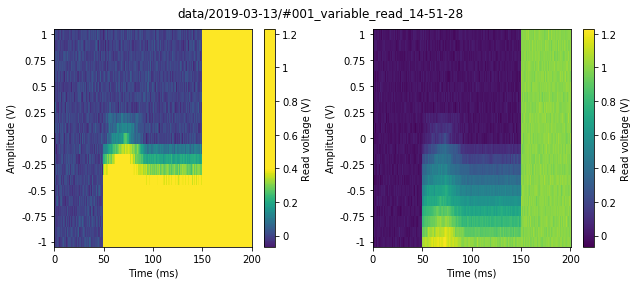

In [27]:
plot = qc.MatPlot(data.read_voltage, data.read_voltage)
plot[1].qcodes_colorbar.set_clim(-0.1, 0.4)

In the right plot we have purposely shifted the colorbar limits, and we can clearly see the existence of a spin-tail!
Note that because we are using qc.MatPlot in combination with a dataset array, all the axis values and labels are automatically taken care of!